In [1]:
#!pip install shap
#!pip install xgboost==0.90
#!pip install seaborn
#!pip install sklearn==0.0

In [13]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import math 
#from pandas_profiling import ProfileReport
from scipy import stats
from xgboost import XGBClassifier
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
#from matplotlib import colors
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
from datetime import datetime as dt
#from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTENC
#from collections import Counter
import pickle
from datetime import datetime
#from tqdm import tqdm
#import seaborn as sn
import shap

In [14]:
data = pd.read_csv('data_aprobada_scoring.csv', encoding= 'unicode_escape')
columnas = data.columns

#RENOMBRO
data = data.rename(columns={ 'Quash_Decision' : 'default'})

#CAMBIO ORDEN EN DEFAULT
data["default"] = 1 - data["default"]
data["default"].value_counts()

data = data.drop(['Unnamed: 0'], axis=1)

#LEO ARTEFACTOS
#CATEGORICAL FEATURES
with open('categorical_features.pkl', 'rb') as f:
    categorical_features = pickle.load(f)
categorical_features


#FEATURE_HEADERS
with open('feature_headers.pkl', 'rb') as f:
    feature_headers = pickle.load(f)
feature_headers


#THRESHOLD
with open('threshold.pkl', 'rb') as f:
    threshold = pickle.load(f)
threshold

#XGB
with open('xgb.pkl', 'rb') as f:
    model = pickle.load(f)
model

Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.


XGBClassifier(base_score=0.5, booster='gbtree', colsample=1.0,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=2.702531932239014, learning_rate=0.5860243690292941,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              n_estimators=499, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1.0, verbosity=1)

In [15]:
feature_headers

Index(['cantidad_Dependientes', 'TiempoRelacionBanco', 'IngresoMensual',
       'edad', 'antiguedad_empleo', 'score', 'max_dias_atraso',
       'ratio_i_sprom', 'ratio_i_spas', 'ratio_i_cuotas',
       'Descripcion_Nivel_Educacion__Maestria',
       'Descripcion_Nivel_Educacion__OTROS',
       'Descripcion_Nivel_Educacion__Secundaria',
       'Descripcion_Nivel_Educacion__SinEscolaridad',
       'Descripcion_Nivel_Educacion__Universitario', 'Estadocivil__MARRIED',
       'Estadocivil__OTHER', 'Estadocivil__OTROS', 'Estadocivil__SINGLE',
       'Genero__FEMALE', 'Genero__MALE', 'Cargo__ABOGADO',
       'Cargo__ADMINISTRADOR', 'Cargo__AGENTECOMERCIAL', 'Cargo__COMERCIANTE',
       'Cargo__DIRECTOR', 'Cargo__GERENTESUBGERENTE', 'Cargo__OTROS',
       'DescripcionIndustria__ACUICULTURAPESCADERIA',
       'DescripcionIndustria__ADMINISTRACION',
       'DescripcionIndustria__AGRICULTURAAGRONOMIA',
       'DescripcionIndustria__ALIMENTOS',
       'DescripcionIndustria__ARQUITECTURAYURBANISMO'

In [16]:
data.head()

cantidad_Dependientes  TiempoRelacionBanco  IngresoMensual       edad  \
0                      0                   22        42104.96  48.320548   
1                      0                   22        30000.00  40.783562   
2                      2                   27         3000.00  60.531507   
3                      3                    5         9625.00  50.967123   
4                      3                    5         9625.00  52.715068   

   antiguedad_empleo  score  max_dias_atraso  ratio_i_sprom  ratio_i_spas  \
0                NaN    NaN              NaN            NaN           NaN   
1                NaN    NaN              0.0       5.292023     17.255278   
2           2.917808    NaN              NaN            NaN           NaN   
3                NaN  803.0              0.0       5.820174      6.665559   
4                NaN  803.0              0.0       5.820174      3.025697   

   ratio_i_cuotas  Default  Descripcion_Nivel_Educacion__Maestria  \
0             NaN        1                                      0   
1        0.115206        1                                      0   
2             NaN        1                                      0   
3        0.763471        1                                      0   
4        0.763471        1                                      0   

   Descripcion_Nivel_Educacion__OTROS  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   Descripcion_Nivel_Educacion__Secundaria  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Descripcion_Nivel_Educacion__SinEscolaridad  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   Descripcion_Nivel_Educacion__Universitario  Estadocivil__MARRIED  \
0                                           1                     0   
1                                           1                     1   
2                                           1                     1   
3                                           0                     0   
4                                           0                     0   

   Estadocivil__OTHER  Estadocivil__OTROS  Estadocivil__SINGLE  \
0                   0                   0                    1   
1                   0                   0                    0   
2                   0                   0                    0   
3                   0                   0                    1   
4                   0                   0                    1   

   Genero__FEMALE  Genero__MALE  Cargo__ABOGADO  Cargo__ADMINISTRADOR  \
0               0             1               0                     0   
1               0             1               0                     0   
2               0             1               0                     0   
3               0             1               0                     0   
4               0             1               0                     0   

   Cargo__AGENTECOMERCIAL  Cargo__COMERCIANTE  Cargo__DIRECTOR  \
0                       0                   0                1   
1                       0                   0                1   
2                       0                   0                0   
3                       0                   0                0   
4                       0                   0                0   

   Cargo__GERENTESUBGERENTE  Cargo__OTROS  \
0                         0             0   
1                         0             0   
2                         0             1   
3  

In [17]:
#data['Quash_Score']

In [18]:
#data = data.drop(['Unnamed: 0',"Quash_Score"], axis=1)

In [19]:
def prepareDataFrame(feature_headers, model,data):

    X = data.drop(['default','Quash_Score'],axis=1)
    Y = data[['default','Quash_Score']]

    seed = 42
    test_size = 0.25
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    feature_headers.shape
    c1 = list(feature_headers)

    c2 = list(X.columns)
    X.shape

    var = list(set(c1).difference(c2))
 
    X = X[feature_headers]

    X_test = X_test[feature_headers]
    X_train = X_train[feature_headers]

    data1 = {'Variables':  X.columns,
            'Importancia': model.feature_importances_
            }

    df = pd.DataFrame (data1, columns  = ['Variables','Importancia'])

    df = df.sort_values(by=['Importancia'], ascending=False)
    print(df)
    
    df = df.loc[:,~df.columns.duplicated()].copy()
    explainer_xgb = shap.TreeExplainer(model)

    #(X_test.isnull().sum() / len(X_test)*100).sort_values(ascending = False)

    shap_values_xgb_train = explainer_xgb.shap_values(X_train)
    shap_values_xgb_test = explainer_xgb.shap_values(X_test)

    shap_values_xgb_test = np.asarray(shap_values_xgb_test)
    shap_values_xgb_train = np.asarray(shap_values_xgb_train)
            
    return (explainer_xgb, shap_values_xgb_test, shap_values_xgb_train, X_test, y_test, X_train, y_train)

In [20]:
(explainer_xgb, shap_values_xgb_test, shap_values_xgb_train, X_test, y_test, X_train, y_train) = prepareDataFrame(feature_headers,model,data)

                                         Variables  Importancia
5                                            score     0.145737
8                                     ratio_i_spas     0.082546
6                                  max_dias_atraso     0.066581
4                                antiguedad_empleo     0.052485
27                                    Cargo__OTROS     0.047266
..                                             ...          ...
33       DescripcionIndustria__ASESORIAYASISTENCIA     0.000000
34          DescripcionIndustria__BELLEZAYESTETICA     0.000000
36              DescripcionIndustria__CONTABILIDAD     0.000000
37  DescripcionIndustria__ELECTRICIDADYELECTRONICA     0.000000
39                  DescripcionIndustria__MEDICINA     0.000000

[64 rows x 2 columns]


In [21]:
len(X_test)

836

In [22]:
print('Expected Value:', explainer_xgb.expected_value)

Expected Value: 1.5210936


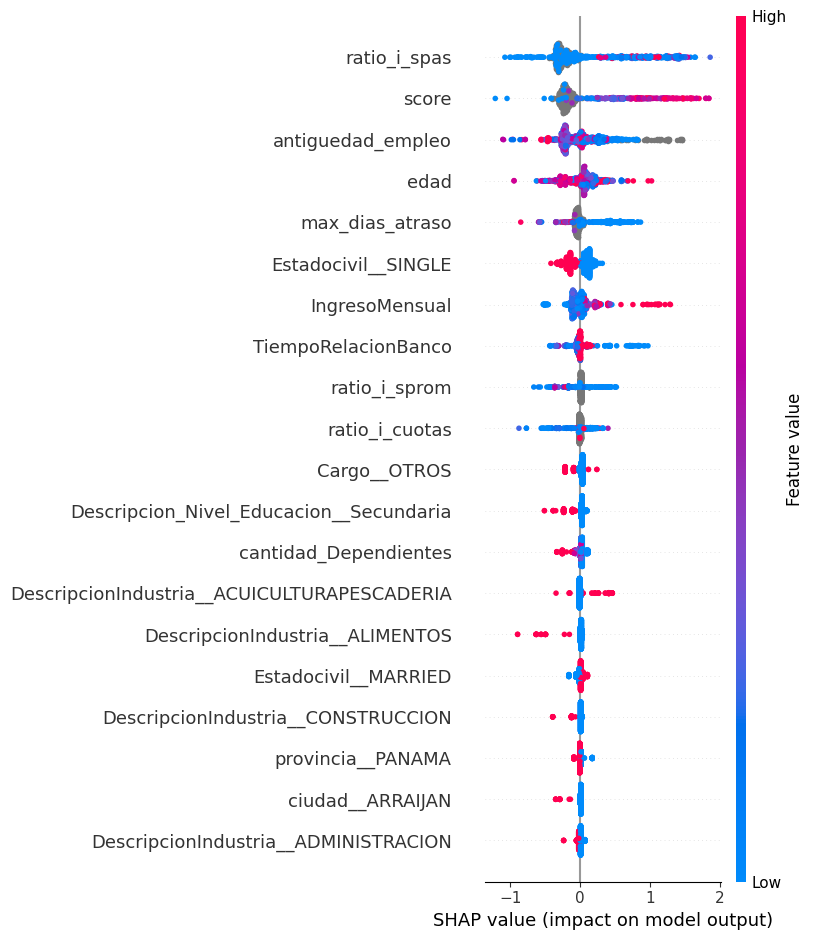

In [23]:
#GRAFICO 1
shap.summary_plot(shap_values_xgb_test, X_test)

In [13]:
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb_test, X_test)

In [15]:
y_test = y_test.reset_index(drop = True)

In [16]:
X_test = X_test.reset_index(drop = True)

In [17]:
X_test

cantidad_Dependientes  TiempoRelacionBanco  IngresoMensual  DIAS_MORA_UM  \
0                        1                   22         3825.00           0.0   
1                        2                    5         2998.19           NaN   
2                        2                   22        29485.33           0.0   
3                        0                    7         5000.00           0.0   
4                        0                   22       125000.00           NaN   
..                     ...                  ...             ...           ...   
831                      0                    5         5000.00           NaN   
832                      0                   22        12000.00           0.0   
833                      0                   22        10615.43           0.0   
834                      2                    4         5000.00           NaN   
835                      2                   22        12000.00           0.0   

     DIAS_MORA_U3M  SALDO_PAS_UM  SALDO_TDC_UM  SALDO_CONS_UM  SALDO_HIPO_UM  \
0              0.0     115813.95      10095.30      106440.00            NaN   
1              NaN        365.34           NaN            NaN            NaN   
2              0.0      47684.84      29879.30       83299.67       65461.89   
3              0.0           NaN       4005.10            NaN            NaN   
4              NaN   10604282.27           NaN            NaN            NaN   
..             ...           ...           ...            ...            ...   
831            NaN           NaN           NaN            NaN            NaN   
832            0.0           NaN      14382.11            NaN            NaN   
833            0.0        411.00       3427.34            NaN            NaN   
834            NaN           NaN           NaN            NaN            NaN   
835            0.0           NaN      47728.89            NaN            NaN   

     SALDO_AUTO_UM       edad  antiguedad_empleo  min_score  max_dias_atraso  \
0              NaN  53.052055           7.753425        NaN              NaN   
1              NaN  26.558904           1.000000        NaN              NaN   
2              NaN  28.969863           7.726027        NaN              NaN   
3              NaN  40.046575                NaN        NaN              NaN   
4              NaN  59.980822          23.342466        NaN              NaN   
..             ...        ...                ...        ...              ...   
831            NaN  40.172603           3.580822        NaN              NaN   
832            NaN  43.871233           8.438356        NaN              NaN   
833            NaN  29.112329           8.498630        NaN              NaN   
834            NaN  57.841096          25.841096        NaN              NaN   
835            NaN  59.473973          22.515068        NaN              NaN   

     ratio_i_sprom  Descripcion_Nivel_Educacion__Maestria  \
0              NaN                                      1   
1              NaN                                      0   
2              NaN                                      0   
3              NaN                                      0   
4              NaN                                      0   
..             ...                                    ...   
831            NaN                                      0   
832            NaN                                      0   
833            NaN                                      0   
834            NaN                                      0   
835            NaN                                      0   

     Descripcion_Nivel_Educacion__OTROS  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
..                                  ...   
831                                   0   
832                              

In [18]:
filtro= (X_test.SALDO_TDC_UM.isna()) & (X_test.SALDO_CONS_UM.isna()) & (X_test.SALDO_HIPO_UM.isna()) & (X_test.SALDO_AUTO_UM.isna())
filtro2= (X_test.DIAS_MORA_UM.isna()) & (X_test.DIAS_MORA_U3M.isna()) & (X_test.SALDO_PAS_UM.isna()) 
#X_test[filtro]

In [130]:
#X_test[filtro & filtro2].head(40)

In [90]:
X_test[filtro & filtro2].index

Int64Index([  1,  12,  13,  16,  25,  26,  27,  28,  29,  31,
            ...
            793, 794, 801, 806, 807, 809, 814, 815, 819, 824],
           dtype='int64', length=233)

In [91]:
y_test_f = y_test.iloc[X_test[filtro & filtro2].index,:]

In [ ]:
[0, 2, 3]
X_test.iloc[[0, 1, 12, 13, 41],:]

In [33]:
y_test[y_test.Quash_Score<=0.55]

default  Quash_Score
10         1     0.059167
19         1     0.037033
21         1     0.090133
23         1     0.040959
41         1     0.382165
63         1     0.259876
70         1     0.401192
108        1     0.493397
162        1     0.102663
170        1     0.109396
176        1     0.179407
216        1     0.473044
245        1     0.065229
256        1     0.216412
260        1     0.422436
274        1     0.071609
289        1     0.037931
307        1     0.054430
341        1     0.051510
381        1     0.061549
384        1     0.510733
413        1     0.473044
434        1     0.078630
468        1     0.036082
486        1     0.088036
526        1     0.116561
538        1     0.456509
552        1     0.332596
553        1     0.050961
559        1     0.040859
566        1     0.051114
567        1     0.538836
568        1     0.036970
599        1     0.072441
610        1     0.056373
634        1     0.545801
635        1     0.051258
636        1     0.047742
650        1     0.048829
657        1     0.052708
659        1     0.051275
677        1     0.086454
678        1     0.047839
709        1     0.354473
711        1     0.525709
733        1     0.224120
736        1     0.341325
744        1     0.070588
777        1     0.538836

In [19]:
y_test.describe()

default  Quash_Score
count  836.000000   836.000000
mean     0.063397     0.794419
std      0.243822     0.182801
min      0.000000     0.036082
25%      0.000000     0.740661
50%      0.000000     0.830612
75%      0.000000     0.909863
max      1.000000     0.987632

In [20]:
y_test[y_test.Quash_Score >= 0.9876]

default  Quash_Score
302        0     0.987632

In [21]:
y_test[y_test.Quash_Score <= 0.79]

default  Quash_Score
0          1     0.558834
2          0     0.753022
4          0     0.759949
6          0     0.737029
7          0     0.785081
..       ...          ...
829        0     0.642363
830        0     0.768909
832        0     0.736610
833        0     0.770461
835        0     0.710105

[329 rows x 2 columns]

In [22]:
X_test.iloc[302,:]

ingreso                       NaN
cantidad_Dependientes        1.00
TiempoRelacionBanco          2.00
IngresoMensual           39090.94
DIAS_MORA_UM                  NaN
                           ...   
ciudad__DAVID                0.00
ciudad__LACHORRERA           0.00
ciudad__OTROS                0.00
ciudad__PANAMA               1.00
ciudad__SANMIGUELITO         0.00
Name: 302, Length: 74, dtype: float64

In [23]:
y_test.iloc[302,:]

default        0.000000
Quash_Score    0.987632
Name: 302, dtype: float64

In [24]:
y_test.iloc[830,:]

default        0.000000
Quash_Score    0.768909
Name: 830, dtype: float64

In [64]:
y_test.iloc[[0, 1, 12, 13, 41,384],:]

default  Quash_Score
0          1     0.558834
1          0     0.876521
12         0     0.870042
13         0     0.862582
41         1     0.382165
384        1     0.510733

In [65]:
X_test.iloc[[0, 1, 12, 13, 41,384],:]

ingreso  cantidad_Dependientes  TiempoRelacionBanco  IngresoMensual  \
0        NaN                      0                   22          4000.0   
1        NaN                      0                    5          1500.0   
12       NaN                      0                    5          1500.0   
13       NaN                      0                    5          3000.0   
41       NaN                      0                    6         12500.0   
384      NaN                      0                    5          4500.0   

     DIAS_MORA_UM  DIAS_MORA_U3M  SALDO_PAS_UM  SALDO_TDC_UM  SALDO_CONS_UM  \
0             NaN            0.0           NaN           NaN            NaN   
1             NaN            NaN           NaN           NaN            NaN   
12            NaN            NaN           NaN           NaN            NaN   
13            NaN            NaN           NaN           NaN            NaN   
41            NaN           25.0           NaN           NaN            NaN   
384           NaN            0.0           NaN           NaN            NaN   

     SALDO_HIPO_UM  ...  provincia__OTROS  provincia__PANAMA  \
0              NaN  ...                 0                  1   
1              NaN  ...                 0                  1   
12             NaN  ...                 0                  1   
13             NaN  ...                 0                  1   
41             NaN  ...                 0                  1   
384            NaN  ...                 0                  1   

     provincia__PANAMAOESTE  provincia__VERAGUAS  ciudad__ARRAIJAN  \
0                         0                    0                 0   
1                         0                    0                 0   
12                        0                    0                 0   
13                        0                    0                 0   
41                        0                    0                 0   
384                       0                    0                 0   

     ciudad__DAVID  ciudad__LACHORRERA  ciudad__OTROS  ciudad__PANAMA  \
0                0                   0              0               1   
1                0                   0              0               1   
12               0                   0              0               1   
13               0                   0              0               1   
41               0                   0              0               1   
384              0                   0              0               1   

     ciudad__SANMIGUELITO  
0                       0  
1                       0  
12                      0  
13                      0  
41                      0  
384                     0  

[6 rows x 74 columns]

In [26]:
y_test.iloc[63,:]

default        1.000000
Quash_Score    0.259876
Name: 63, dtype: float64

In [123]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[42,:], X_test.iloc[42,:])

In [126]:
X_test[(X_test.TiempoRelacionBanco == 1) & (X_test.Cargo__ADMINISTRADOR ==1)].head(1)

ingreso  cantidad_Dependientes  TiempoRelacionBanco  IngresoMensual  \
86      NaN                      2                    1          6000.0   

    DIAS_MORA_UM  DIAS_MORA_U3M  SALDO_PAS_UM  SALDO_TDC_UM  SALDO_CONS_UM  \
86           NaN            NaN           NaN           NaN            NaN   

    SALDO_HIPO_UM  SALDO_AUTO_UM       edad  antiguedad_empleo  \
86            NaN            NaN  39.194521           2.290411   

    segmento__LOCALRETAIL?MA  segmento__OTROS  \
86                         0                0   

    Descripcion_Nivel_Educacion__Maestria  Descripcion_Nivel_Educacion__OTROS  \
86                                      0                                   0   

    Descripcion_Nivel_Educacion__Secundaria  \
86                                        0   

    Descripcion_Nivel_Educacion__SinEscolaridad  \
86                                            0   

    Descripcion_Nivel_Educacion__Universitario  Estadocivil__MARRIED  \
86                                           1                     0   

    Estadocivil__OTHER  Estadocivil__OTROS  Estadocivil__SINGLE  \
86                   1                   0                    0   

    Genero__FEMALE  Genero__MALE  Cargo__ABOGADO  Cargo__ADMINISTRADOR  \
86               1             0               0                     1   

    Cargo__AGENTECOMERCIAL  Cargo__COMERCIANTE  Cargo__DIRECTOR  \
86                       0                   0                0   

    Cargo__GERENTESUBGERENTE  Cargo__OTROS  \
86                         0             0   

    DescripcionIndustria__ACUICULTURAPESCADERIA  \
86                                            1   

    DescripcionIndustria__ADMINISTRACION  \
86                                     0   

    DescripcionIndustria__AGRICULTURAAGRONOMIA  \
86                                           0   

    DescripcionIndustria__ALIMENTOS  \
86                                0   

    DescripcionIndustria__ARQUITECTURAYURBANISMO  \
86                                             0   

    DescripcionIndustria__ASESORIAYASISTENCIA  \
86                                          0   

    DescripcionIndustria__BELLEZAYESTETICA  \
86                                       0   

    DescripcionIndustria__CONSTRUCCION  DescripcionIndustria__CONTABILIDAD  \
86                                   0                                   0   

    DescripcionIndustria__ELECTRICIDADYELECTRONICA  \
86                                               0   

    DescripcionIndustria__LEGAL  DescripcionIndustria__MEDICINA  \
86                            0                               0   

    DescripcionIndustria__MERCANCIA  DescripcionIndustria__OTROS  \
86                                0                            0   

    DescripcionIndustria__PUBLICIDADYMERCADEO  \
86                                          0   

    DescripcionIndustria__RESTAURANTESYSERVICIOS  \
86                                             0   

    DescripcionIndustria__ROPACALZADOYACCESORIOS  \
86                                             0   

    DescripcionIndustria__SERVICIODECONSULTORIA  \
86                                            0   

    DescripcionIndustria__TECNOLOGIADEINFORMACION  \
86                                              0   

    DescripcionIndustria__TRANSPORTETERRESTRE  DescripcionSector__OTROS  \
86                                          0                         0   

    DescripcionSector__PNatural  SubTipoCliente__-  \
86                            1                  1   

    SubTipoCliente__ClienteRegular  SubTipoCliente__OTROS  pais__OTROS  \
86                               0                      0            0   

    pais__PANAMA  provincia__CHIRIQUI  provincia__COCLE  provincia__COLON  \
86             1                    0                 0                 0   

    provincia__HERRERA  provincia__OTROS  provincia__PANAMA  \
86                   0                 0                  1   

    provincia__PANAMAOESTE  p

In [124]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[86,:], X_test.iloc[86,:])

In [112]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[77,:], X_test.iloc[77,:])

In [113]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[229,:], X_test.iloc[229,:])

In [114]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[543,:], X_test.iloc[543,:])

In [127]:
y_test.iloc[[61,86,42, 77, 229, 543],:]

default  Quash_Score
61         0     0.935241
86         0     0.946576
42         0     0.581363
77         0     0.788871
229        0     0.627050
543        0     0.635794

In [128]:
X_test.iloc[[61,86,42, 77, 229, 543],:]

ingreso  cantidad_Dependientes  TiempoRelacionBanco  IngresoMensual  \
61       0.0                      0                    1         1000.00   
86       NaN                      2                    1         6000.00   
42       NaN                      0                    3         3500.00   
77       NaN                      0                    3         8700.00   
229      NaN                      0                    1         1259.79   
543      NaN                      3                    5         4500.00   

     DIAS_MORA_UM  DIAS_MORA_U3M  SALDO_PAS_UM  SALDO_TDC_UM  SALDO_CONS_UM  \
61            NaN            NaN           NaN           NaN            NaN   
86            NaN            NaN           NaN           NaN            NaN   
42            NaN            NaN           NaN           NaN            NaN   
77            NaN            NaN           NaN           NaN            NaN   
229           NaN            NaN           NaN           NaN            NaN   
543           NaN            NaN           NaN           NaN            NaN   

     SALDO_HIPO_UM  SALDO_AUTO_UM       edad  antiguedad_empleo  \
61             NaN            NaN  29.695890           1.378082   
86             NaN            NaN  39.194521           2.290411   
42             NaN            NaN  53.879452          20.427397   
77             NaN            NaN  45.632877           4.087671   
229            NaN            NaN  23.547945           2.747945   
543            NaN            NaN  39.569863          12.336986   

     segmento__LOCALRETAIL?MA  segmento__OTROS  \
61                          0                0   
86                          0                0   
42                          0                0   
77                          0                0   
229                         0                0   
543                         0                0   

     Descripcion_Nivel_Educacion__Maestria  \
61                                       0   
86                                       0   
42                                       0   
77                                       0   
229                                      0   
543                                      0   

     Descripcion_Nivel_Educacion__OTROS  \
61                                    0   
86                                    0   
42                                    0   
77                                    0   
229                                   0   
543                                   0   

     Descripcion_Nivel_Educacion__Secundaria  \
61                                         0   
86                                         0   
42                                         1   
77                                         1   
229                                        1   
543                                        1   

     Descripcion_Nivel_Educacion__SinEscolaridad  \
61                                             0   
86                                             0   
42                                             0   
77                                             0   
229                                            0   
543                                            0   

     Descripcion_Nivel_Educacion__Universitario  Estadocivil__MARRIED  \
61                                            1                     1   
86                                            1                     0   
42                                            0                     1   
77                                            0                     1   
229                                           0                     0   
543                                           0                     1   

     Estadocivil__OTHER  Estadocivil__OTROS  Estadocivil__SINGLE  \
61                    0                   0                    0   
86                    1                   0                    0   
42                    0                   0           

In [108]:
y_test_f[y_test_f.Quash_Score<=0.8]

default  Quash_Score
31         0     0.755060
37         0     0.769655
40         0     0.752662
42         0     0.581363
73         0     0.767855
77         0     0.788871
123        0     0.776161
126        0     0.777691
130        0     0.786520
160        0     0.794745
182        0     0.791287
191        0     0.704780
208        0     0.787932
217        0     0.785841
220        0     0.775085
225        0     0.665345
229        0     0.627050
252        0     0.673323
258        0     0.760144
286        0     0.796835
325        0     0.795813
347        0     0.742064
354        0     0.776864
378        0     0.718447
408        0     0.763080
417        0     0.776161
477        0     0.766035
483        0     0.681345
491        0     0.764460
492        0     0.747866
503        0     0.751675
533        0     0.691227
543        0     0.635794
565        0     0.764749
580        0     0.752662
592        0     0.686516
612        0     0.792104
658        0     0.770717
662        0     0.776349
668        0     0.731644
673        0     0.794436
725        0     0.734035
735        0     0.727683
747        0     0.760144
752        0     0.763480
755        0     0.780084
774        0     0.779921
779        0     0.736379
793        0     0.783426
807        0     0.616668

In [63]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[13,:], X_test.iloc[13,:])

In [60]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[41,:], X_test.iloc[41,:])

In [61]:
#GRAFICO 2
#GRAFICO BUEN PAGADOR - SCORE DE 0.987632
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb_test[384,:], X_test.iloc[384,:])

In [115]:
#GRAFICO SCORE PROMEDIO - 0.768909
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb[830,:], X_test.iloc[830,:])

In [113]:
#GRAFICO MAL PAGADOR - SCORE : 0.259876            256  63  552
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_xgb[63,:], X_test.iloc[63,:])

In [34]:
X_test.columns

Index(['ingreso', 'cantidad_Dependientes', 'TiempoRelacionBanco',
       'IngresoMensual', 'DIAS_MORA_UM', 'DIAS_MORA_U3M', 'SALDO_PAS_UM',
       'SALDO_TDC_UM', 'SALDO_CONS_UM', 'SALDO_HIPO_UM', 'SALDO_AUTO_UM',
       'edad', 'antiguedad_empleo', 'segmento__LOCALRETAIL?MA',
       'segmento__OTROS', 'Descripcion_Nivel_Educacion__Maestria',
       'Descripcion_Nivel_Educacion__OTROS',
       'Descripcion_Nivel_Educacion__Secundaria',
       'Descripcion_Nivel_Educacion__SinEscolaridad',
       'Descripcion_Nivel_Educacion__Universitario', 'Estadocivil__MARRIED',
       'Estadocivil__OTHER', 'Estadocivil__OTROS', 'Estadocivil__SINGLE',
       'Genero__FEMALE', 'Genero__MALE', 'Cargo__ABOGADO',
       'Cargo__ADMINISTRADOR', 'Cargo__AGENTECOMERCIAL', 'Cargo__COMERCIANTE',
       'Cargo__DIRECTOR', 'Cargo__GERENTESUBGERENTE', 'Cargo__OTROS',
       'DescripcionIndustria__ACUICULTURAPESCADERIA',
       'DescripcionIndustria__ADMINISTRACION',
       'DescripcionIndustria__AGRICULTURAAGRON

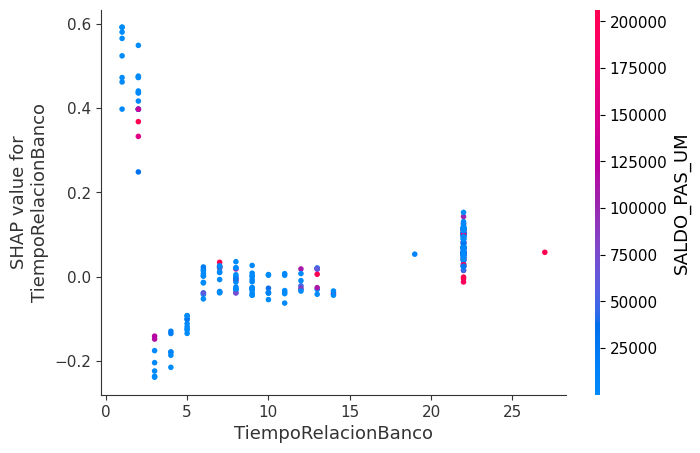

In [39]:
#GRAFICO 3
## Dependence plots
#shap.dependence_plot("TOTAL_FINANCIAR", shap_values_xgb[:1000], X_test[:1000], interaction_index="DAYS_EMPLOYED")
shap.dependence_plot("TiempoRelacionBanco", shap_values_xgb, X_test, interaction_index="SALDO_PAS_UM")

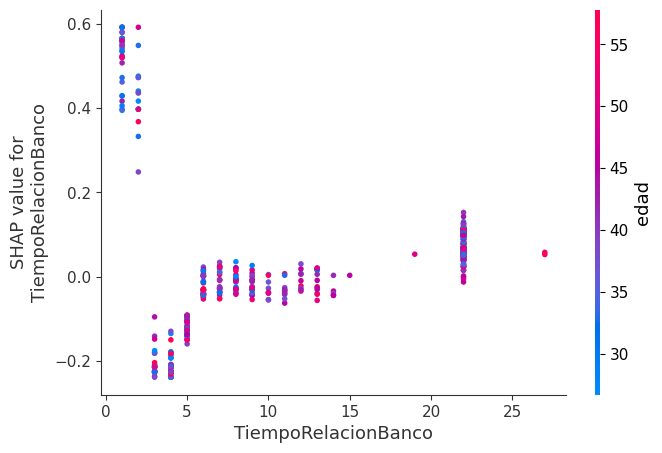

In [38]:
shap.dependence_plot("TiempoRelacionBanco", shap_values_xgb, X_test, interaction_index="edad")

In [ ]:
#EXPORTO
#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)
#f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)